In [26]:
!pip install sklearn
!pip install seaborn


You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [140]:
city = 'amsterdam'

In [202]:
import pickle
import numpy as np
import os

import matplotlib.pyplot as plt

from osgeo import gdal
from sklearn import metrics


# A list of "random" colors (for a nicer output)
COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941"]



In [203]:
### import data from other notebook

with open('/home/gremlin/GGCW_tools_git/Pickle/data_all_{}.pickle'.format(city), 'rb') as handle:
    data_all = pickle.load(handle)
    
    
with open('/home/gremlin/GGCW_tools_git/Pickle/label_all_{}.pickle'.format(city), 'rb') as handle:
    label_all = pickle.load(handle)

In [206]:
import pandas as pd

data = pd.DataFrame(data_all.T)


data['class'] = label_all


In [207]:
# Calculate NDVI

# 8-band (0:Coastal, 1:Blue, 2:Green, 3:Yellow, 4:Red, 5:Red-edge, 6:NIR1, 7:NIR2) Multispectral

# ndvi = (nir - red)/(nir + red)

# EVI = 2.5 * ( nir - red ) / ( nir + 6.5 * red - 7.5 * blue+ 1.0 )

data['ndvi'] = (data[6] - data[4])/(data[6] + data[4])

data['EVI'] = 2.5 * (data[6] - data[4]) / (data[6] + 6.5 * data[4] - 7.5 * data[1] + 1 )


data['water_index'] = (data[7] - data[0]) / (data[7] + data[0])

In [208]:

print label_all.shape
print data_all.T.shape

(182963,)
(182963, 8)


In [209]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

In [224]:
X = data.iloc[:,0:8]

y = data['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# initialize search space (as a library!)
param_grid = {
     'max_depth':[1,10,20,50],'n_estimators':[5,20,30,50]
}

gs = make_pipeline(     StandardScaler(), 
                        GridSearchCV(RandomForestClassifier(min_samples_leaf=2),
                        param_grid = param_grid,
                        cv = 2,
                        refit = True,
                        n_jobs = 1,
                        verbose = 2))

# Instantiate random forest. You can specify default parameters here.
# These parameters are not being optimized.


# initialize grid search
#gs = GridSearchCV(rf, param_grid, verbose=2)#,scoring='roc_auc')

gs.fit(X_train,y_train);







Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] n_estimators=5, max_depth=1 .....................................
[CV] ...................... n_estimators=5, max_depth=1, total=   0.1s
[CV] n_estimators=5, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................... n_estimators=5, max_depth=1, total=   0.1s
[CV] n_estimators=20, max_depth=1 ....................................
[CV] ..................... n_estimators=20, max_depth=1, total=   0.4s
[CV] n_estimators=20, max_depth=1 ....................................
[CV] ..................... n_estimators=20, max_depth=1, total=   0.4s
[CV] n_estimators=30, max_depth=1 ....................................
[CV] ..................... n_estimators=30, max_depth=1, total=   0.6s
[CV] n_estimators=30, max_depth=1 ....................................
[CV] ..................... n_estimators=30, max_depth=1, total=   0.5s
[CV] n_estimators=50, max_depth=1 ....................................
[CV] ..................... n_estimators=50, max_depth=1, total=   0.9s
[CV] n_estimators=50, max_depth=1 ....................................
[CV] ..................... n_estimators=50, max_depth=1, total=   0.9s
[CV] n_estimators=5, max_depth=10 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  1.2min finished


In [222]:
from sklearn.metrics import classification_report

y_pred = gs.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        1.0       0.56      0.93      0.70     18736
        2.0       0.00      0.00      0.00     13850
        3.0       0.90      0.72      0.80     12640
        4.0       0.68      0.86      0.76     15152

avg / total       0.53      0.66      0.58     60378



In [218]:
import pickle

# write trained classifier to pickle
with open('/home/gremlin/GGCW_tools_git/Pickle/trained_classifier_{}.pickle'.format(city), 'wb') as handle:
    pickle.dump(gs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# predict


In [212]:
image_array = image.read()

Fetching Image... 6 tiles


In [213]:
# (8, 312, 531)
# n_b, r, c


n_bands, rows, cols = image_array.shape

n_samples = rows*cols

# image_array_flipped = np.fliplr(image_array[:,:,:])
reshaped_data = image_array.reshape(8,(rows*cols))


In [214]:
reshaped_data.T.shape

(188568, 8)

In [215]:

result = gs.predict(reshaped_data.T)
classification = result.T.T.T.reshape((rows, cols))

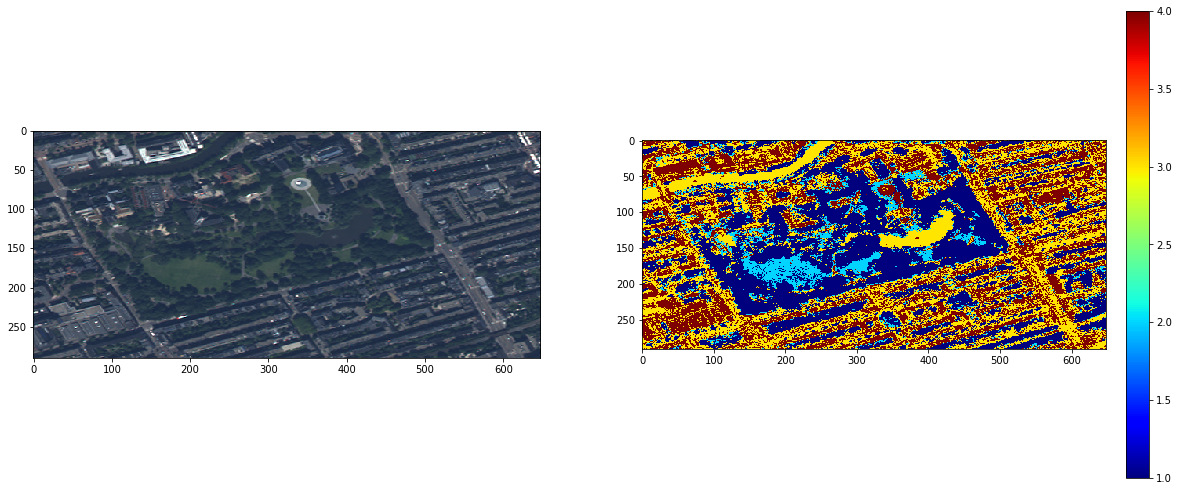

In [216]:
# dict_type = {'Forest': 1,'Wood': 1,'Nature Reserve': 1,'Wetland': 1, 'Grass': 2, 'Water': 3, 'Building': 4}

from mpl_toolkits.axes_grid1 import make_axes_locatable


from matplotlib import pyplot as plt
f = plt.figure( figsize = (20,20))
f.add_subplot(1, 2,1)
r = image_array[3,:,:]
g = image_array[2,:,:]
b = image_array[1,:,:]
rgb = np.dstack([r,g,b])
f.add_subplot(1, 2, 1)
plt.imshow(rgb/3000)
f.add_subplot(1, 2, 2)

im = plt.imshow(classification,cmap='jet')

plt.colorbar(im,fraction=0.046, pad=0.04)